In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Set home directory for organization
import os
HOME = "/kaggle/working"
%cd {HOME}

# 1. Install GroundingDINO
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git
%cd Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd {HOME}

# 2. Install Segment Anything Model 2 (SAM 2)
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -q -e.
%cd {HOME}

# 3. Install the 'supervision' library for visualization
!pip install -q supervision

/kaggle/working
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1807, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 1807 (delta 10), reused 1 (delta 1), pack-reused 1788 (from 2)
Receiving objects: 100% (1807/1807), 155.84 MiB | 41.84 MiB/s, done.
Resolving deltas: 100% (831/831), done.
/kaggle/working/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 11.8 MB/s eta 0:00:

In [3]:
# --- Download GroundingDINO Checkpoint ---
!mkdir -p {HOME}/checkpoints
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -P {HOME}/checkpoints

# --- Download SAM 2 Checkpoints using the official script ---
# This is a more reliable method that executes the script provided in the repository.
%cd {HOME}/segment-anything-2/checkpoints
!bash download_ckpts.sh
%cd {HOME}

# --- Verify downloads in their respective locations ---
print("--- GroundingDINO Checkpoint Location ---")
!ls -lh {HOME}/checkpoints
print("\n--- SAM 2 Checkpoint Location ---")
!ls -lh {HOME}/segment-anything-2/checkpoints

/kaggle/working/segment-anything-2/checkpoints
--2025-10-04 17:44:05--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.59, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M  57.0MB/s    in 2.6s    

2025-10-04 17:44:07 (57.0 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-10-04 17:44:07--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiti

In [4]:
import torch
import cv2
import supervision as sv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import box_convert # <-- ADD THIS LINE

# Set device (GPU is recommended)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add GroundingDINO and SAM 2 to Python path
import sys
sys.path.append(f"{HOME}/Grounded-Segment-Anything/GroundingDINO")
sys.path.append(f"{HOME}/segment-anything-2")

# Import model-specific utilities
from groundingdino.util.inference import load_model, load_image, predict
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# --- Configuration Paths ---
GROUNDING_DINO_CONFIG_PATH = f"{HOME}/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = f"{HOME}/checkpoints/groundingdino_swint_ogc.pth"
SAM2_CHECKPOINT_PATH = f"{HOME}/segment-anything-2/checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG_PATH = f"{HOME}/segment-anything-2/configs/sam2.1/sam2.1_hiera_l.yaml"

print("All paths configured.")

2025-10-04 17:44:43.160439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759599883.370507      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759599883.430848      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All paths configured.


In [5]:
# Temporarily change the working directory to the segment-anything-2 repo
# This allows the hydra library (used by SAM 2) to find its configuration files
%cd {HOME}/segment-anything-2

# Load GroundingDINO model (still using the absolute paths defined in Cell 3)
grounding_dino_model = load_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH).to(DEVICE)

# Load SAM 2 model and create predictor
# We now provide a relative path to the config file, which hydra can resolve.
# The checkpoint path remains absolute and will work correctly.
sam2_model = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml", SAM2_CHECKPOINT_PATH, device=DEVICE)
sam2_predictor = SAM2ImagePredictor(sam2_model)

print("Models loaded successfully.")

# IMPORTANT: Change back to the original working directory for the rest of the notebook
%cd {HOME}

/kaggle/working/segment-anything-2


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Models loaded successfully.
/kaggle/working


In [6]:
# # --- Define Inputs ---
# # Make sure you have added the "COCO 2017 Dataset" to your Kaggle notebook
# # The exact path might vary slightly depending on which version of the dataset you add.
# IMAGE_PATH = "/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000139.jpg"
# TEXT_PROMPT = "person. dog. frisbee"
# BOX_THRESHOLD = 0.35
# TEXT_THRESHOLD = 0.25

# # --- Step 1: Load Image ---
# image_source_pil = Image.open(IMAGE_PATH).convert("RGB")
# image_source_np = np.array(image_source_pil)

# # --- Step 2: Generate Region Seeds with GroundingDINO ---
# # GroundingDINO requires a pre-processed image tensor
# _, image_tensor = load_image(IMAGE_PATH)

# boxes, logits, phrases = predict(
#     model=grounding_dino_model,
#     image=image_tensor,
#     caption=TEXT_PROMPT,
#     box_threshold=BOX_THRESHOLD,
#     text_threshold=TEXT_THRESHOLD,
#     device=DEVICE
# )

# print(f"Detected {len(boxes)} object(s) with prompt: '{TEXT_PROMPT}'")

# # --- Step 3: Feed Seeds to SAM 2 ---
# # Set the image for the SAM 2 predictor
# sam2_predictor.set_image(image_source_np)

# # Convert GroundingDINO's normalized [cx, cy, w, h] boxes to [x1, y1, x2, y2] pixel coordinates
# H, W, _ = image_source_np.shape

# # 1. Convert format from cxcywh to xyxy using the function from torchvision
# # This gives a tensor with normalized  coordinates
# boxes_xyxy_normalized = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

# # 2. Denormalize the coordinates (scale them to the image size)
# # We create a scaling factor tensor and multiply it with the normalized boxes
# scaling_factor = torch.Tensor().to(boxes.device)
# boxes_xyxy = (boxes_xyxy_normalized * scaling_factor).numpy()

# # Predict masks using the bounding box prompts
# with torch.inference_mode():
#     masks, scores, _ = sam2_predictor.predict(
#         box=boxes_xyxy,
#         multimask_output=False,
#     )

# print("Segmentation masks generated by SAM 2.")

In [7]:
# --- Define Inputs ---
# Make sure you have added the "COCO 2017 Dataset" to your Kaggle notebook
# The exact path might vary slightly depending on which version of the dataset you add.
IMAGE_PATH = "/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000139.jpg"
TEXT_PROMPT = "person. chair. tv"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

# --- Step 1: Load Image ---
image_source_pil = Image.open(IMAGE_PATH).convert("RGB")
image_source_np = np.array(image_source_pil)

# --- Step 2: Generate Region Seeds with GroundingDINO ---
# GroundingDINO requires a pre-processed image tensor
_, image_tensor = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=grounding_dino_model,
    image=image_tensor,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE
)

print(f"Detected {len(boxes)} object(s) with prompt: '{TEXT_PROMPT}'")

# --- Step 3: Feed Seeds to SAM 2 ---
# Set the image for the SAM 2 predictor
sam2_predictor.set_image(image_source_np)

# Convert GroundingDINO's normalized [cx, cy, w, h] boxes to [x1, y1, x2, y2] pixel coordinates
H, W, _ = image_source_np.shape

# 1. Convert format from cxcywh to xyxy (normalized coords in [0,1])
boxes_xyxy_normalized = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

# 2. Denormalize to pixel coordinates
scaling = torch.tensor([W, H, W, H], device=boxes.device)  
boxes_xyxy = (boxes_xyxy_normalized * scaling).cpu().numpy()

# --- Step 4: Predict masks using the bounding box prompts
with torch.inference_mode():
    masks, scores, _ = sam2_predictor.predict(
        box=boxes_xyxy,
        multimask_output=False,
    )

print("Segmentation masks generated by SAM 2.")


Detected 7 object(s) with prompt: 'person. chair. tv'
Segmentation masks generated by SAM 2.


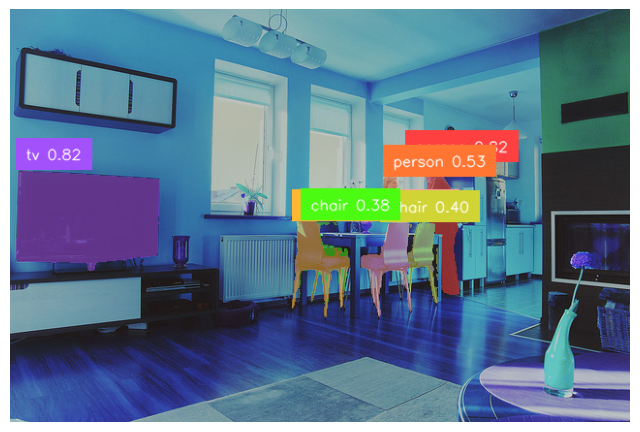

In [8]:
# --- Step 4: Display the Final Mask Overlay ---

if masks is not None and len(masks) > 0:
    # Ensure masks are in shape [N, H, W]
    if masks.ndim == 4:   # [N, 1, H, W]
        masks = masks.squeeze(1)
    elif masks.ndim == 2: # single mask [H, W]
        masks = masks[None, ...]

    # Create Detections object (align masks + boxes + labels)
    detections = sv.Detections(
        xyxy=boxes_xyxy,          # bounding boxes from GroundingDINO
        mask=masks.astype(bool)   # masks from SAM 2
    )

    # Create annotators (force INDEX lookup to avoid class_id error)
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

    # Generate labels from detected phrases
    labels = [f"{phrase} {logit:.2f}" for phrase, logit in zip(phrases, logits)]

    # Annotate image
    annotated_image = mask_annotator.annotate(scene=image_source_np.copy(), detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

    # Display
    sv.plot_image(annotated_image, size=(8, 8))

else:
    print("No objects were detected that met the threshold criteria. Try lowering the BOX_THRESHOLD.")
    plt.figure(figsize=(8, 8))
    plt.imshow(image_source_np)
    plt.title("Original Image (No Detections)")
    plt.axis('off')
    plt.show()


In [9]:
# --- Define Inputs ---
# Make sure you have added the "Driving Video with Object Tracking" dataset
SOURCE_VIDEO_PATH = "/kaggle/input/sample-video-data-2/sample video data.mp4"
TEXT_PROMPT = "person"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

# --- Define Output Locations ---
VIDEO_FRAMES_DIR = f"{HOME}/video_frames"
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"

# Create the directory for storing frames
os.makedirs(VIDEO_FRAMES_DIR, exist_ok=True)

print("Extracting video frames...")

# Get a generator that yields frames from the video
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Create an ImageSink to save the frames to the specified directory
sink = sv.ImageSink(
    target_dir_path=VIDEO_FRAMES_DIR,
    image_name_pattern="{:05d}.jpeg"
)

# Loop through the frames and save each one using the sink
with sink:
    for frame in frames_generator:
        sink.save_image(image=frame)

print(f"Frames extracted and saved to {VIDEO_FRAMES_DIR}")

Extracting video frames...
Frames extracted and saved to /kaggle/working/video_frames


In [10]:
import torch
import cv2
import supervision as sv
from PIL import Image
import numpy as np
import os
from torchvision.ops import box_convert
from IPython.display import HTML
from base64 import b64encode

# Set device (GPU is recommended)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add repository paths to Python's system path
import sys
sys.path.append(f"{HOME}/Grounded-Segment-Anything/GroundingDINO")
sys.path.append(f"{HOME}/segment-anything-2")

# Import model-specific utilities
from groundingdino.util.inference import load_model, load_image, predict
from sam2.build_sam import build_sam2_video_predictor # <-- This is the required import for video

# --- Configuration Paths ---
GROUNDING_DINO_CONFIG_PATH = f"{HOME}/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = f"{HOME}/checkpoints/groundingdino_swint_ogc.pth"
SAM2_CHECKPOINT_PATH = f"{HOME}/segment-anything-2/checkpoints/sam2.1_hiera_large.pt"

print("All libraries imported and paths configured.")

All libraries imported and paths configured.


In [11]:
# Temporarily change directory to load SAM 2 model correctly
%cd {HOME}/segment-anything-2

# Load GroundingDINO model
grounding_dino_model = load_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH).to(DEVICE)

# Load SAM 2 Video Predictor
sam2_video_predictor = build_sam2_video_predictor(
    "configs/sam2.1/sam2.1_hiera_l.yaml",
    SAM2_CHECKPOINT_PATH,
    device=DEVICE
)

print("Models loaded successfully.")

# Change back to the home directory
%cd {HOME}

/kaggle/working/segment-anything-2
final text_encoder_type: bert-base-uncased
Models loaded successfully.
/kaggle/working


In [12]:
# --- Define Inputs ---
# PASTE THE CORRECT FILE PATH YOU COPIED FROM THE INPUT PANE HERE
SOURCE_VIDEO_PATH = "/kaggle/input/sample-video-data-2/sample video data.mp4" # <-- FIX THIS LINE
TEXT_PROMPT = "car"
BOX_THRESHOLD = 0.15
TEXT_THRESHOLD = 0.05

# --- Define Output Locations ---
VIDEO_FRAMES_DIR = f"{HOME}/video_frames"
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"

# Create the directory for storing frames
os.makedirs(VIDEO_FRAMES_DIR, exist_ok=True)

print("Extracting video frames...")

# Get a generator that yields frames from the video
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Create an ImageSink to save the frames to the specified directory
sink = sv.ImageSink(
    target_dir_path=VIDEO_FRAMES_DIR,
    image_name_pattern="{:05d}.jpeg"
)

# Loop through the frames and save each one using the sink
with sink:
    for frame in frames_generator:
        sink.save_image(image=frame)

print(f"Frames extracted and saved to {VIDEO_FRAMES_DIR}")

Extracting video frames...
Frames extracted and saved to /kaggle/working/video_frames


In [13]:
# --- Initialize Tracking on the First Frame (ann_frame_idx = 0) ---
ann_frame_idx = 50
frame_paths = sorted(sv.list_files_with_extensions(directory=VIDEO_FRAMES_DIR, extensions=["jpeg"]))
first_frame_path = frame_paths[ann_frame_idx]

# Load the first frame for GroundingDINO
image_source_pil = Image.open(first_frame_path).convert("RGB")
_, image_tensor = load_image(first_frame_path)

# Run GroundingDINO prediction on the first frame
boxes, logits, phrases = predict(
    model=grounding_dino_model,
    image=image_tensor,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device=DEVICE
)

print(f"Detected {len(boxes)} object(s) on the first frame.")

# --- Initialize SAM 2 Video State ---
print("Initializing SAM 2 video state...")
inference_state = sam2_video_predictor.init_state(VIDEO_FRAMES_DIR)

# --- Prompt SAM 2 with the initial bounding boxes ---
# Convert and scale boxes to pixel coordinates
H, W, _ = np.array(image_source_pil).shape
# Convert boxes from [cx, cy, w, h] normalized to [x1, y1, x2, y2] pixel coordinates
boxes_xyxy_normalized = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

# Denormalize to pixel coordinates
boxes_xyxy = boxes_xyxy_normalized.clone()
boxes_xyxy[:, 0] *= W  # x1
boxes_xyxy[:, 1] *= H  # y1
boxes_xyxy[:, 2] *= W  # x2
boxes_xyxy[:, 3] *= H  # y2

initial_boxes = boxes_xyxy.cpu().numpy()

# Add each detected box to the video predictor to start tracking
with torch.inference_mode():
    for i, box in enumerate(initial_boxes):
        object_id = i + 1 # Assign a unique ID to each object
        sam2_video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            box=box,
        )
print(f"Initialized tracking for {len(initial_boxes)} object(s).")

Detected 1 object(s) on the first frame.
Initializing SAM 2 video state...


frame loading (JPEG): 100%|██████████| 115/115 [00:11<00:00,  9.92it/s]


Initialized tracking for 1 object(s).



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).


In [14]:
# # --- Initialize Tracking on the First Frame (ann_frame_idx = 0) ---
# ann_frame_idx = 0
# frame_paths = sorted(sv.list_files_with_extensions(directory=VIDEO_FRAMES_DIR, extensions=["jpeg"]))

# # --- ERROR CHECK ---
# # Verify that frames were extracted in the previous cell.
# if not frame_paths:
#     raise FileNotFoundError(
#         f"No frames found in '{VIDEO_FRAMES_DIR}'. "
#         "This usually means the 'SOURCE_VIDEO_PATH' in Cell 4 is incorrect or the video file is corrupted. "
#         "Please double-check the path to your video file and run Cell 4 again."
#     )
# # --- END ERROR CHECK ---

# first_frame_path = frame_paths[ann_frame_idx]

# # Load the first frame for GroundingDINO
# image_source_pil = Image.open(first_frame_path).convert("RGB")
# _, image_tensor = load_image(first_frame_path)

# # Run GroundingDINO prediction on the first frame
# boxes, logits, phrases = predict(
#     model=grounding_dino_model,
#     image=image_tensor,
#     caption=TEXT_PROMPT,
#     box_threshold=BOX_THRESHOLD,
#     text_threshold=TEXT_THRESHOLD,
#     device=DEVICE
# )

# print(f"Detected {len(boxes)} object(s) on the first frame.")

# # --- Initialize SAM 2 Video State ---
# print("Initializing SAM 2 video state...")
# inference_state = sam2_video_predictor.init_state(VIDEO_FRAMES_DIR)

# # --- Prompt SAM 2 with the initial bounding boxes ---
# # Convert and scale boxes to pixel coordinates
# H, W, _ = np.array(image_source_pil).shape
# boxes_xyxy_normalized = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")
# scaling_factor = torch.Tensor().to(boxes.device)
# initial_boxes = (boxes_xyxy_normalized * scaling_factor).cpu().numpy()

# # Add each detected box to the video predictor to start tracking
# with torch.inference_mode():
#     for i, box in enumerate(initial_boxes):
#         object_id = i + 1 # Assign a unique ID to each object
#         sam2_video_predictor.add_new_points_or_box(
#             inference_state=inference_state,
#             frame_idx=ann_frame_idx,
#             obj_id=object_id,
#             box=box,
#         )
# print(f"Initialized tracking for {len(initial_boxes)} object(s).")

In [15]:
# # --- Initialize Tracking on the First Frame (ann_frame_idx = 0) ---
# ann_frame_idx = 0
# frame_paths = sorted(sv.list_files_with_extensions(directory=VIDEO_FRAMES_DIR, extensions=["jpeg"]))

# # --- ERROR CHECK ---
# # Verify that frames were extracted in the previous cell.
# if not frame_paths:
#     raise FileNotFoundError(
#         f"No frames found in '{VIDEO_FRAMES_DIR}'. "
#         "This usually means the 'SOURCE_VIDEO_PATH' in Cell 4 is incorrect. "
#         "Please double-check the path to your video file and run Cell 4 again."
#     )
# # --- END ERROR CHECK ---

# first_frame_path = frame_paths[ann_frame_idx]

# # Load the first frame for GroundingDINO
# image_source_pil = Image.open(first_frame_path).convert("RGB")
# _, image_tensor = load_image(first_frame_path)

# # Run GroundingDINO prediction on the first frame
# boxes, logits, phrases = predict(
#     model=grounding_dino_model,
#     image=image_tensor,
#     caption=TEXT_PROMPT,
#     box_threshold=BOX_THRESHOLD,
#     text_threshold=TEXT_THRESHOLD,
#     device=DEVICE
# )

# # --- ERROR CHECK ---
# # Verify that GroundingDINO detected at least one object.
# if len(boxes) == 0:
#     raise ValueError(
#         f"No objects detected in the first frame for the prompt '{TEXT_PROMPT}'. "
#         "Try lowering the BOX_THRESHOLD or TEXT_THRESHOLD in Cell 4, or use a different prompt."
#     )
# # --- END ERROR CHECK ---

# print(f"Detected {len(boxes)} object(s) on the first frame.")

# # --- Initialize SAM 2 Video State ---
# print("Initializing SAM 2 video state...")
# inference_state = sam2_video_predictor.init_state(VIDEO_FRAMES_DIR)

# # --- Prompt SAM 2 with the initial bounding boxes ---
# # Convert and scale boxes to pixel coordinates
# H, W, _ = np.array(image_source_pil).shape
# boxes_xyxy_normalized = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

# # Denormalize to pixel coordinates using the correct scaling factor
# scaling_factor = torch.Tensor().to(boxes.device)
# initial_boxes = (boxes_xyxy_normalized * scaling_factor).cpu().numpy()

# # Add each detected box to the video predictor to start tracking
# with torch.inference_mode():
#     for i, box in enumerate(initial_boxes):
#         object_id = i + 1 # Assign a unique ID to each object
#         sam2_video_predictor.add_new_points_or_box(
#             inference_state=inference_state,
#             frame_idx=ann_frame_idx,
#             obj_id=object_id,
#             box=box,
#         )
# print(f"Initialized tracking for {len(initial_boxes)} object(s).")

In [16]:
print("Propagating masks through the video...")
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Set up annotators for visualization
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX, text_position=sv.Position.CENTER)

# Open a video sink to write the annotated frames
with sv.VideoSink(target_path=OUTPUT_VIDEO_PATH, video_info=video_info) as sink:
    # Iterate through the video frames and get propagated masks
    for frame_idx, object_ids, mask_logits in sam2_video_predictor.propagate_in_video(inference_state):
        frame = cv2.imread(frame_paths[frame_idx])
        
        # Convert logits to binary masks
        masks = (mask_logits > 0.0).cpu().numpy()
        
        # Reshape masks for supervision library
        if masks.ndim == 4:
            masks = masks.squeeze(1)

        # Create a Detections object to hold the tracking results for this frame
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=np.array(object_ids)
        )
        
        # Create labels for each tracked object
        labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]
        
        # Annotate the frame with masks and labels
        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
        
        # Write the annotated frame to the output video
        sink.write_frame(annotated_frame)

print(f"Video processing complete. Output saved to {OUTPUT_VIDEO_PATH}")

Propagating masks through the video...


propagate in video: 100%|██████████| 65/65 [26:40<00:00, 24.62s/it]

Video processing complete. Output saved to /kaggle/working/output.mp4
